In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from dowhy import gcm
from sklearn.linear_model import LinearRegression

# Set colours for plots
COLORS = [
    '#00B0F0',
    '#FF0000',
    '#B0F000'
]

In [38]:
def plot_graph(input_graph, node_lookup):
    '''
    Function to visualise graphs.

    Args:
        input_graph (array): Adjacency matrix representing graph
        node_lookup (dict): Dictionary containing node names.
    '''
    
    graph = nx.DiGraph(input_graph)

    plt.figure(figsize=(7, 7))
    nx.draw(
    G=graph,
    node_color=COLORS[0],
    node_size=7000,
    arrowsize=17,
    with_labels=True,
    labels=node_lookup,
    font_color='white',
    font_size=9,
    pos=nx.circular_layout(graph)
    )

In [12]:
def data_generator(node_lookup, population, observations, include):
    '''
    A data generating function which has the flexibility to delete nodes - Comparisons of including vs deleting a selected node enables us to calculate ground truth counterfactuals.

    Args:
        node_lookup (dict): Dictionary containing node names.
        population (int): The population size to use when generating the root nodes.
        observations (int): The number of observations to create in the data.
        include (array): Array which indicates whether to include each node (corresponding to the node_lookup). 1 = include / 0 = delete.

    Returns:
        DataFrame: Dataframe containing the generated data.
    '''
    
    df = pd.DataFrame(columns=node_lookup.values())
    df[node_lookup[0]] = (population * np.random.uniform(0.90, 0.95, observations)) * include[0]
    df[node_lookup[1]] = (population * np.random.uniform(0.50, 0.75, observations)) * include[1]
    df[node_lookup[2]] = (0.50 * df[node_lookup[1]]) * include[2]
    df[node_lookup[3]] = ((0.35 * df[node_lookup[0]]) + (0.20 * df[node_lookup[1]])) * include[3]
    df[node_lookup[4]] = ((0.05 * df[node_lookup[0]]) + (0.10 * df[node_lookup[2]]) + (0.20 * df[node_lookup[3]]))
    
    return df

In [53]:
def counterfactual_impact(target_value_act, target_value_cf):
    '''
    Given an actual and counterfactual target value, calculate the percentage change.

    Args:
        target_value_act (series): Series containing the actual target value.
        target_value_cf (series): Series containing the counterfactual target value.

    Returns:
        float: The counterfactual percentage change to the target value.
    '''
    
    target_change_perc = round((target_value_act.sum() - target_value_cf.sum()) / target_value_act.sum(), 2)
    
    return target_change_perc

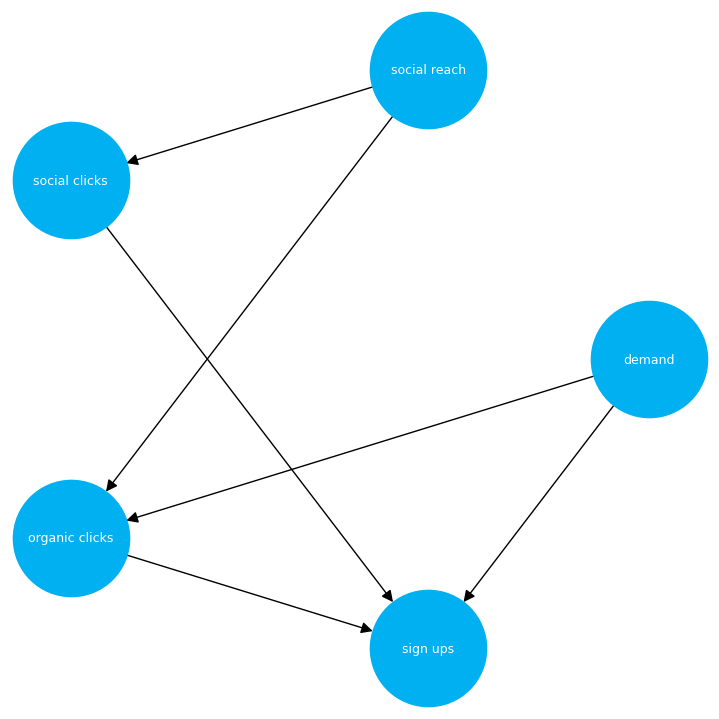

In [39]:
# Create node lookup for channels
node_lookup = {0: 'demand',
    1: 'social reach',                
    2: 'social clicks',
    3: 'organic clicks',
    4: 'sign ups'                                                                             
 }

total_nodes = len(node_lookup)

# Create adjacency matrix - this is the basis for our known graph
graph_actual = np.zeros((total_nodes, total_nodes))

# Create known graph using expert domain knowledge
graph_actual[0, 3] = 1.0 # demand -> organic clicks
graph_actual[0, 4] = 1.0 # demand -> signups

graph_actual[1, 2] = 1.0 # social reach -> social clicks
graph_actual[1, 3] = 1.0 # social reach -> organic clicks

graph_actual[2, 4] = 1.0 # social clicks -> signups
graph_actual[3, 4] = 1.0 # organic clicks -> signups

plot_graph(input_graph=graph_actual, node_lookup=node_lookup)

In [14]:
# Setup graph
graph = nx.from_numpy_array(graph_actual, create_using=nx.DiGraph)
graph = nx.relabel_nodes(graph, node_lookup)

In [45]:
# Set random seed
np.random.seed(999)

# Generate data
df_original = data_generator(node_lookup=node_lookup, population=10000, observations=365, include=[1, 1, 1, 1])
df_del_social = data_generator(node_lookup=node_lookup, population=10000, observations=365, include=[1, 0, 1, 1])
df_del_demand = data_generator(node_lookup=node_lookup, population=10000, observations=365, include=[0, 1, 1, 1])

In [54]:
counterfactual_impact(target_value_act=df_original['sign ups'], target_value_cf=df_del_social['sign ups'])

In [55]:
counterfactual_impact(target_value_act=df_original['sign ups'], target_value_cf=df_del_demand['sign ups'])

Fitting causal mechanism of node social clicks:   0%|          | 0/5 [00:00<?, ?it/s]

Test permutations of given graph: 100%|██████████| 50/50 [00:03<00:00, 13.48it/s]


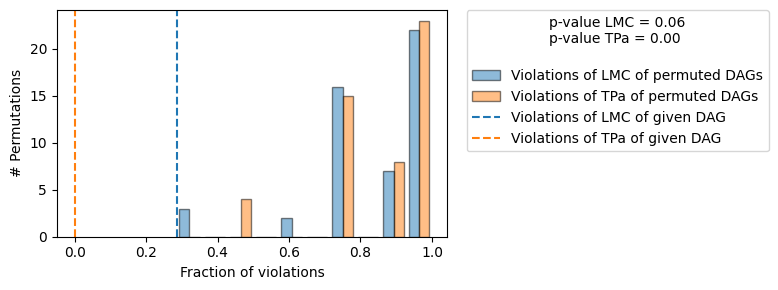

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [47]:
# Create SCM
causal_model = gcm.InvertibleStructuralCausalModel(graph)
causal_model.set_causal_mechanism('demand', gcm.EmpiricalDistribution())
causal_model.set_causal_mechanism('social reach', gcm.EmpiricalDistribution())
causal_model.set_causal_mechanism('social clicks', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism('organic clicks', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism('sign ups', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
gcm.fit(causal_model, df_original)

# Check model fit statistics
print(gcm.evaluate_causal_model(causal_model, df_original))

In [56]:
df_cf_social = gcm.counterfactual_samples(causal_model, {'social reach': lambda x: 0}, observed_data=df_original)
counterfactual_impact(target_value_act=df_original['sign ups'], target_value_cf=df_cf_social['sign ups'])

In [57]:
df_cf_demand = gcm.counterfactual_samples(causal_model, {'demand': lambda x: 0}, observed_data=df_original)
counterfactual_impact(target_value_act=df_original['sign ups'], target_value_cf=df_cf_demand['sign ups'])

In [60]:
# Linear regression
y = df_original['sign ups'].copy()
X = df_original[['social reach', 'demand']].copy()
lin_model = LinearRegression()
lin_model = lin_model.fit(X, y)
y_pred = lin_model.predict(X)

# Printing the coefficients
print(f'Intercept: {lin_model.intercept_}')
print(f'Coefficient: {lin_model.coef_}')

Intercept: 0.0
Coefficient: [0.09 0.12]


In [74]:
round((df_original['social reach'].sum() * lin_model.coef_[0]) / df_original['sign ups'].sum(), 2)

In [75]:
round((df_original['demand'].sum() * lin_model.coef_[1]) / df_original['sign ups'].sum(), 2)

In [68]:
# Check for multi-collinearity
# Can we check linear regression coefficients in gcm
# What happens when you include all variables

In [ ]:
# Normalise counterfactual estimates
# Enforce coefficient constraints
# Carry out intervention